In [1]:
sat_formula = [[1],[-2]]
#sat_formula = [[1,2],[-1,2],[-1,-2]]
#sat_formula = [[1,2,3],[-1,-2],[-3]]
#sat_formula = [[1,2],[-1,-2]]
#sat_formula = [[1,2,3]]
print(sat_formula)

formula_string = ''
for i in sat_formula:
    formula_string = formula_string + '('
    for j in i:
        if(j<0):
            formula_string = formula_string + '-'
            j = j*-1
        formula_string = formula_string + 'x_' + str(j) + ' OR '
    formula_string = formula_string[:-4] + ') AND '
formula_string = formula_string[:-5]
print('Formula:',formula_string)

num_of_clauses = len(sat_formula)
num_of_variables = 0
for clause in sat_formula:
    for i in clause:
        if abs(i) > num_of_variables:
            num_of_variables = abs(i)

print('number of clauses:',num_of_clauses)
print('number of variables:',num_of_variables)

[[1], [-2]]
Formula: (x_1) AND (-x_2)
number of clauses: 2
number of variables: 2


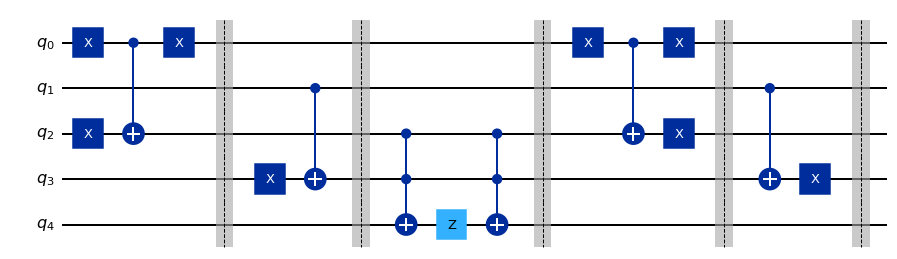

In [2]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

from math import pi

oracle = QuantumCircuit(num_of_variables + num_of_clauses + 1)

#for clause_num in range(num_of_clauses):
#    oracle.x(num_of_variables+clause_num)
#oracle.barrier()

for clause_num in range(num_of_clauses):
    clause = sat_formula[clause_num]
    control_states = []
    for i in clause:
        control_states.append(abs(i)-1)
        if(i > 0):
            oracle.x(i-1)
    oracle.x(num_of_variables+clause_num)
    oracle.mcx(control_states, num_of_variables+clause_num)
    for i in clause:
        if(i > 0):
            oracle.x(i-1)
    oracle.barrier()
    
control_states = []
for i in range(num_of_variables,num_of_variables+num_of_clauses):
    control_states.append(i)
oracle.mcx(control_states, num_of_variables + num_of_clauses)
oracle.z(num_of_variables + num_of_clauses)
oracle.mcx(control_states, num_of_variables + num_of_clauses)
oracle.barrier()

for clause_num in range(num_of_clauses):
    clause = sat_formula[clause_num]
    control_states = []
    for i in clause:
        control_states.append(abs(i)-1)
        if(i > 0):
            oracle.x(i-1)
    oracle.mcx(control_states, num_of_variables+clause_num)
    oracle.x(num_of_variables+clause_num)
    for i in clause:
        if(i > 0):
            oracle.x(i-1)
    oracle.barrier()
    
#for clause_num in range(num_of_clauses):
#    oracle.x(num_of_variables+clause_num)
#oracle.barrier()

#oracle.measure(range(num_of_variables + num_of_clauses + 1),range(num_of_variables + num_of_clauses + 1))

#job = execute(oracle,Aer.get_backend('qasm_simulator'),shots=10000)
#counts = job.result().get_counts(oracle)
#print(counts)
            
oracle.draw(output='mpl')

Formula: (x_1) AND (-x_2)
Solutions:
x_1 = 1, x_2 = 0 - with probability 100.0%
{'01': 10000}


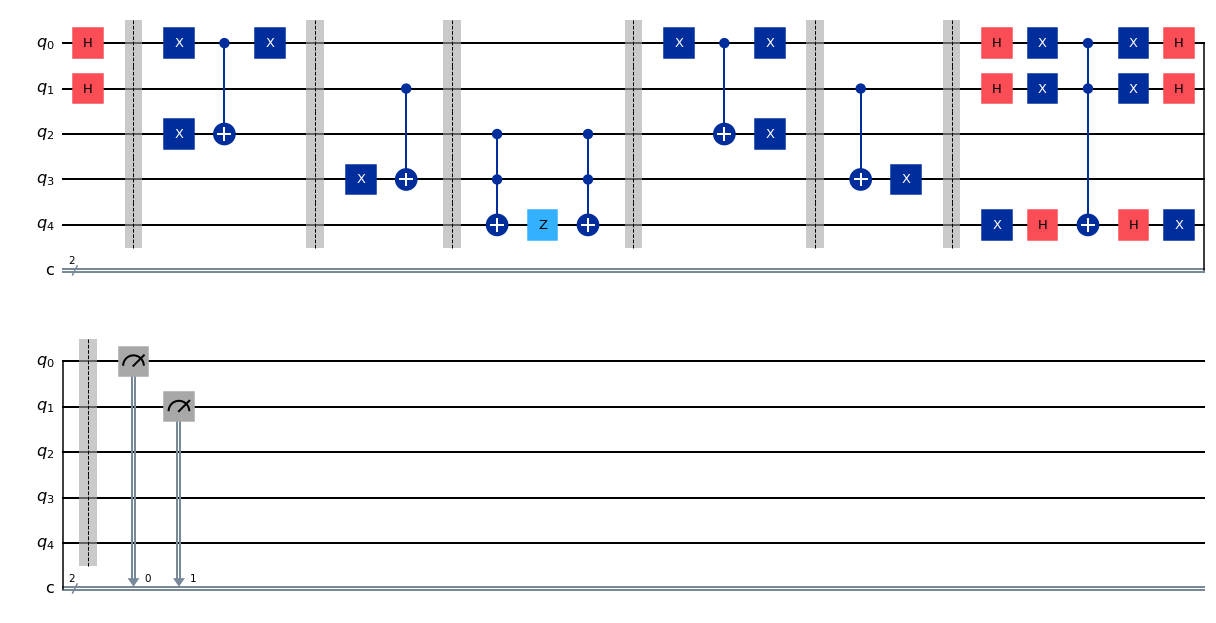

In [3]:
number_of_iterations = 1

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit_aer import AerSimulator
from math import pi

grover = QuantumCircuit(num_of_variables + num_of_clauses + 1, num_of_variables)

for i in range(num_of_variables):
    grover.h(i)
grover.barrier()

for i in range(number_of_iterations):
    grover = grover.compose(oracle)
    
    for j in range(num_of_variables):
        grover.h(j)
    grover.x(num_of_variables + num_of_clauses)
    for j in range(num_of_variables):
        grover.x(j)
    grover.h(num_of_variables + num_of_clauses)
    control_states = []
    for j in range(num_of_variables):
        control_states.append(j)
    grover.mcx(control_states, num_of_variables + num_of_clauses)
    for j in range(num_of_variables):
        grover.x(j)
    grover.h(num_of_variables + num_of_clauses)
    for j in range(num_of_variables):
        grover.h(j)
    grover.x(num_of_variables + num_of_clauses)
    grover.barrier()

grover.measure(range(num_of_variables),range(num_of_variables))

job = AerSimulator().run(grover,shots=10000)
counts = job.result().get_counts(grover)

print('Formula:',formula_string)
print('Solutions:')
for i in counts:
    result_to_print = ''
    for j in range(num_of_variables):
        result_to_print = result_to_print + 'x_' + str(j+1) + ' = ' + i[len(i)-j-1] + ', '
    result_to_print = result_to_print[:-2] + ' - with probability ' + str(counts[i]/100) + '%'
    print(result_to_print)
print(counts)
grover.draw(output='mpl')

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService.save_account(
    
)

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()

print('Least busy:')
service.least_busy(simulator=False, operational=True, min_num_qubits=5)

Least busy:


<IBMBackend('ibm_fez')>

In [6]:
backend = service.backend("ibm_marrakesh")

from qiskit import transpile

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
isa_circuit = pm.run(grover)

from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(mode=backend)

job = sampler.run([isa_circuit], shots=4000)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: d5imrsqgim5s73aj7o40
>>> Job Status: QUEUED


In [7]:
result = job.result()
# Get results for the first (and only) PUB
pub_result = result[0]
print(pub_result.data.c.get_counts())

{'01': 3176, '00': 347, '11': 310, '10': 167}


In [8]:
backend = service.backend("ibm_fez")

from qiskit import transpile

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
isa_circuit = pm.run(grover)

from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(mode=backend)

job = sampler.run([isa_circuit], shots=4000)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: d5imteigim5s73aj7pmg
>>> Job Status: QUEUED


In [9]:
result = job.result()
# Get results for the first (and only) PUB
pub_result = result[0]
print(pub_result.data.c.get_counts())

{'01': 2973, '00': 346, '11': 475, '10': 206}


In [10]:
backend = service.backend("ibm_torino")

from qiskit import transpile

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
isa_circuit = pm.run(grover)

from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(mode=backend)

job = sampler.run([isa_circuit], shots=4000)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: d5imth7ea9qs7393epd0
>>> Job Status: QUEUED


In [11]:
result = job.result()
# Get results for the first (and only) PUB
pub_result = result[0]
print(pub_result.data.c.get_counts())

{'10': 208, '01': 2954, '11': 583, '00': 255}


In [12]:
backend = service.backend("ibm_marrakesh")

from qiskit import transpile

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
isa_circuit = pm.run(grover)

from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(mode=backend)

job = sampler.run([isa_circuit], shots=4000)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: d5imuvf67pic7386lgr0
>>> Job Status: QUEUED


In [13]:
result = job.result()
# Get results for the first (and only) PUB
pub_result = result[0]
print(pub_result.data.c.get_counts())

{'01': 2956, '00': 353, '11': 424, '10': 267}


In [14]:
backend = service.backend("ibm_fez")

from qiskit import transpile

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
isa_circuit = pm.run(grover)

from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(mode=backend)

job = sampler.run([isa_circuit], shots=4000)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: d5in04n67pic7386li00
>>> Job Status: QUEUED


In [15]:
result = job.result()
# Get results for the first (and only) PUB
pub_result = result[0]
print(pub_result.data.c.get_counts())

{'01': 1478, '10': 475, '00': 517, '11': 1530}


In [16]:
backend = service.backend("ibm_torino")

from qiskit import transpile

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
isa_circuit = pm.run(grover)

from qiskit_ibm_runtime import SamplerV2 as Sampler
sampler = Sampler(mode=backend)

job = sampler.run([isa_circuit], shots=4000)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: d5in07nea9qs7393es7g
>>> Job Status: QUEUED


In [17]:
result = job.result()
# Get results for the first (and only) PUB
pub_result = result[0]
print(pub_result.data.c.get_counts())

{'01': 2424, '11': 456, '00': 780, '10': 340}
